# Vergleich Tabellen 'transaction_lines'

## Einlesen  & Überblick Trainingsdaten

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind, chi2_contingency

# Daten laden
df_train = pd.read_parquet('data/transaction_lines_train_1.parquet')
df_test = pd.read_parquet('data/transaction_lines_test_1.parquet')

# 1. Überblick
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16620157 entries, 0 to 16620156
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   transaction_id          object        
 2   product_id              object        
 3   timestamp               datetime64[us]
 4   pieces_or_weight        float64       
 5   sales_price             float64       
 6   was_voided              bool          
 7   camera_product_similar  object        
 8   camera_certainty        float64       
dtypes: bool(1), datetime64[us](1), float64(3), int64(1), object(3)
memory usage: 1.0+ GB
None


## Überblick Testdaten

In [2]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8647089 entries, 0 to 8647088
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   transaction_id          object        
 2   product_id              object        
 3   timestamp               datetime64[us]
 4   pieces_or_weight        float64       
 5   sales_price             float64       
 6   was_voided              bool          
 7   camera_product_similar  object        
 8   camera_certainty        float64       
dtypes: bool(1), datetime64[us](1), float64(3), int64(1), object(3)
memory usage: 536.0+ MB
None


## Vergleich numerischer Daten

id: KS-Test p-Wert = 0.00022


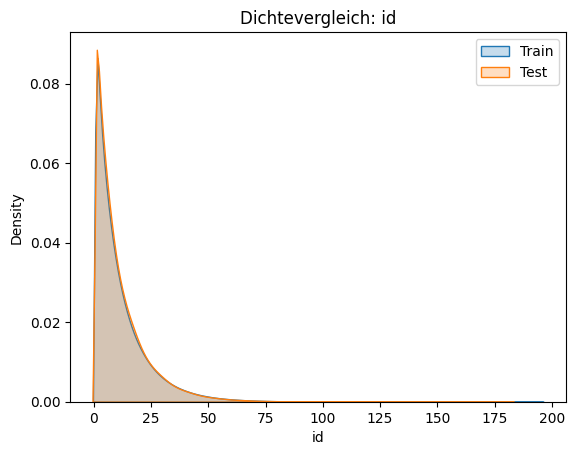

pieces_or_weight: KS-Test p-Wert = 0.00000


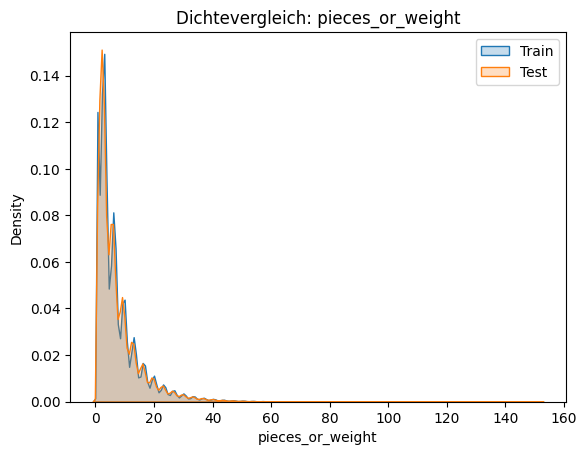

sales_price: KS-Test p-Wert = 0.00000


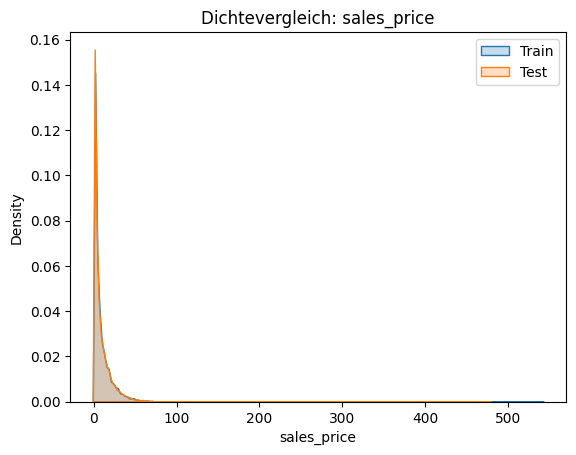

camera_certainty: KS-Test p-Wert = 0.00000


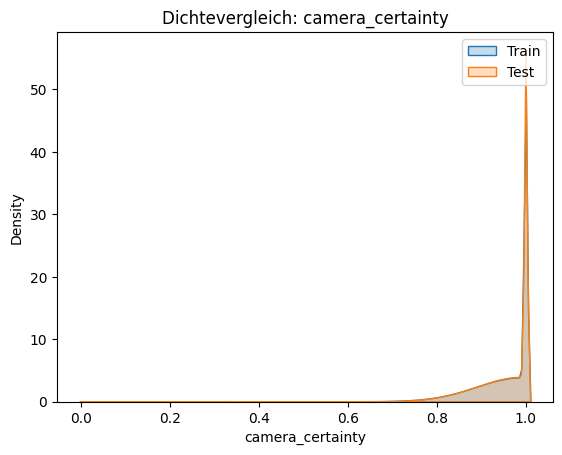

In [3]:
# Spaltenschnittmenge ermitteln (nur gemeinsame Spalten)
common_cols = df_train.columns.intersection(df_test.columns)

# Nur numerische gemeinsame Spalten vergleichen
numerical_cols = df_train[common_cols].select_dtypes(include='number').columns

# KS-Test für numerische Features
for col in numerical_cols:
    train_vals = df_train[col].dropna()
    test_vals = df_test[col].dropna()
    
    stat, p = ks_2samp(train_vals, test_vals)
    print(f"{col}: KS-Test p-Wert = {p:.5f}")
    
    sns.kdeplot(train_vals, label='Train', fill=True)
    sns.kdeplot(test_vals, label='Test', fill=True)
    plt.title(f'Dichtevergleich: {col}')
    plt.legend()
    plt.show()

--> Die numerischen Merkmale der Transaktionszeilen wurden auf Verteilungsgleichheit geprüft. Die geprüften numerischen Merkmale pieces_or_weight, sales_price und camera_certainty zeigten signifikante Unterschiede zwischen Trainings- und Testdaten (alle p < 0.001). Die visuelle Überprüfung bestätigte systematische Verteilungsschwankungen. Daraus ergeben sich Anforderungen an robuste Vorverarbeitung, mögliche Normalisierung sowie eventuelle Re-Kalibrierung der Features im Modellkontext.

## Vergleich kategorischer Daten

transaction_id: Chi-Quadrat-Test p-Wert = 0.00000 (Top 20 Kategorien)


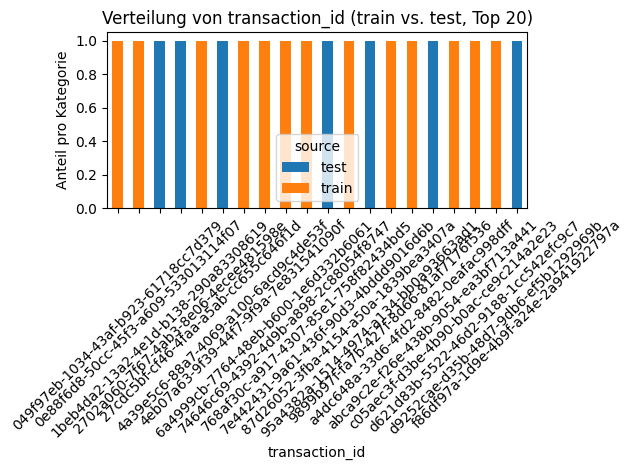

product_id: Chi-Quadrat-Test p-Wert = 0.95664 (Top 20 Kategorien)


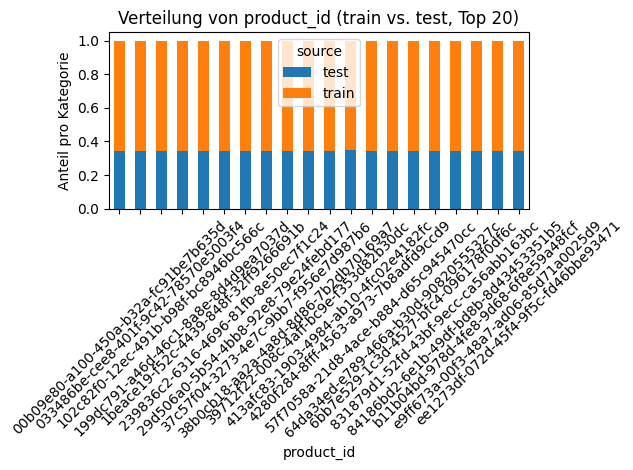

camera_product_similar: Chi-Quadrat-Test p-Wert = 0.00000 (Top 20 Kategorien)


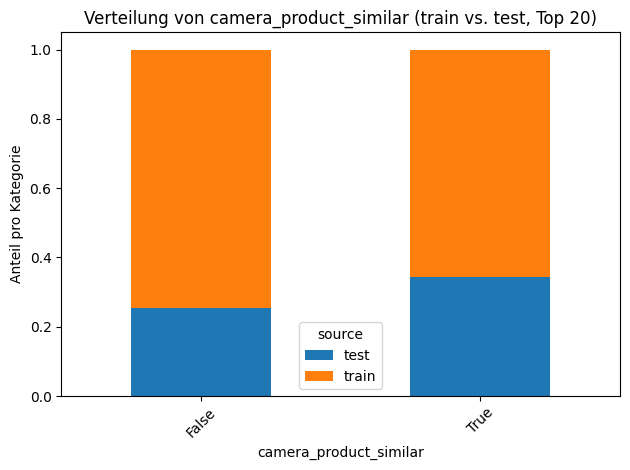

In [4]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt

# Nur gemeinsame kategoriale Spalten
common_cols = df_train.columns.intersection(df_test.columns)
categorical_cols = df_train[common_cols].select_dtypes(include=['object', 'category']).columns

# Kombinierten DataFrame mit Kennzeichnung der Quelle
df_train_ = df_train[categorical_cols].copy()
df_train_['source'] = 'train'

df_test_ = df_test[categorical_cols].copy()
df_test_['source'] = 'test'

df_all = pd.concat([df_train_, df_test_], axis=0)

# Chi-Quadrat-Test pro Spalte
TOP_K = 20  # Anzahl der häufigsten Kategorien

for col in categorical_cols:
    # Häufigste Kategorien in train + test
    top_cats = df_all[col].value_counts().nlargest(TOP_K).index

    df_filtered = df_all[df_all[col].isin(top_cats)]

    contingency = pd.crosstab(df_filtered[col], df_filtered['source'])

    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f"{col}: Chi-Quadrat-Test p-Wert = {p:.5f} (Top {TOP_K} Kategorien)")

        contingency.div(contingency.sum(1), axis=0).plot(kind='bar', stacked=True)
        plt.title(f"Verteilung von {col} (train vs. test, Top {TOP_K})")
        plt.ylabel("Anteil pro Kategorie")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col}: Nicht genug Variation für Chi-Quadrat-Test.")

--> Die kategorialen Merkmale wurden im Rahmen der explorativen Datenanalyse auf Gleichverteilung zwischen Trainings- und Testdaten geprüft. Dabei zeigte sich, dass product_id keine signifikanten Unterschiede aufweist (p = 0.96), was auf eine stabile Produktverteilung hindeutet. Hingegen ergaben sich deutliche Unterschiede bei camera_product_similar (p < 0.001), was auf eine Veränderung in der Produkterkennung hinweist. 